In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers, reporter
from chainer import Link, Chain, ChainList
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

from matplotlib import pyplot as plt
import cupy as cp

import itertools

In [0]:
train, test = datasets.get_mnist(withlabel=True, ndim=2)

In [0]:
train_images, train_labels = train._datasets[0],train._datasets[1]
test_images, test_labels = test._datasets[0],test._datasets[1]
del(train)
del(test)


In [4]:
gpu = chainer.cuda.available
if gpu
    xp = cp
else:
    xp = np

anchor_images = np.empty((1,28,28)).astype(np.float32)
training_images = np.empty((1,10,28,28)).astype(np.float32)
for i in range(10):
    if i == 0:
        class_i_images = train_images[np.random.choice(np.where(train_labels == i)[0],11)] #Sample 11 images of class i
        to_anchor, to_train = class_i_images[-1], class_i_images[:-1]
        anchor_images[i] = to_anchor.reshape(1,28,28)
        training_images[i] = to_train.reshape(1,10,28,28)
    else:
        class_i_images = train_images[np.random.choice(np.where(train_labels == i)[0],11)]
        to_anchor, to_train = class_i_images[-1], class_i_images[:-1]
        to_anchor = to_anchor.reshape(1,28,28)
        to_train = to_train.reshape(1,10,28,28)

        anchor_images = np.vstack((anchor_images, to_anchor))
        training_images = np.vstack((training_images, to_train)) 
print(anchor_images.shape)
print(training_images.shape)

(10, 28, 28)
(10, 10, 28, 28)


In [0]:
class SiameseNetwork(Chain):

    def __init__(self):
        super(SiameseNetwork, self).__init__(
            conv1=L.Convolution2D(1, 20, ksize=5, stride=1),
            conv2=L.Convolution2D(20, 50, ksize=5, stride=1),
            fc3=L.Linear(800, 500),
            fc4=L.Linear(500, 10),
            fc5=L.Linear(10, 2),
        )

    def single_forward(self, x_data, train=True):
        x = Variable(x_data)
        x = F.reshape(x, (-1,1,28,28))
        
        h = F.max_pooling_2d(self.conv1(x), ksize=2, stride=2)
        h = F.max_pooling_2d(self.conv2(h), ksize=2, stride=2)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        y = self.fc5(h)

        return y

    def __call__(self, anchor_img, pos_img, neg_img, train=True):
        anchor_encoding = self.single_forward(anchor_img)
        pos_img_encoding = self.single_forward(pos_img)
        neg_img_encoding = self.single_forward(neg_img)
        

        return (anchor_encoding, pos_img_encoding, neg_img_encoding)



In [0]:
def predict(image, model):
    sample_output = model.single_forward(xp.asarray(image)).data
    anchor_outputs = model.single_forward(xp.asarray(anchor_images)).data

    sample_output = xp.repeat(sample_output,10,axis=0)
    diff = sample_output - anchor_outputs
    diff_sq = diff**2

    
    return xp.asnumpy(xp.argmin(xp.sum(diff_sq,axis =1)))


def get_validation(model):
    right = wrong = 0
    for index in range(test_images.shape[0]):
    if predict(test_images[index], model) == test_labels[index]:
        right += 1
    else:
        wrong += 1
    return (right/(right+wrong))

In [7]:
my_model = SiameseNetwork()
if gpu:
    my_model.to_gpu()

optimizer = optimizers.SGD()
optimizer.setup(my_model)

epoch_losses = []
validation_accuracy = []
for epoch in range(15):
    epoch_loss = 0
    for pos_id,neg_id in itertools.combinations(range(10),2):
    for pos_image in training_images[pos_id]:
        anchor = anchor_images[pos_id]
        batch_anchor = xp.asarray(np.repeat(np.reshape(anchor,(-1,28,28)),10,axis=0))


        batch_pos_image = xp.asarray(np.repeat(cp.reshape(pos_image,(-1,28,28)),10,axis=0))
        batch_neg_image = xp.asarray(training_images[neg_id])


        anchor_encoding, pos_img_encoding, neg_img_encoding = my_model(batch_anchor, 
                                                                 batch_pos_image,
                                                                 batch_neg_image)

        my_model.cleargrads()
        loss = F.triplet(anchor_encoding, pos_img_encoding, neg_img_encoding, margin=.75)
        epoch_loss += loss
        loss.backward()
        optimizer.update()
    validation_acc = get_validation(my_model)
    validation_accuracy.append(validation_acc)

    print("epoch no: %02i  \tloss: %6.2f  \tvalidation acc: %5.2f"%(epoch,epoch_loss.data,validation_acc))
    epoch_losses.append(epoch_loss.data)
  
      
#plt.plot(epoch_losses)      
      
      
    
    
  
  

epoch no: 00  	loss:  37.17  	validation acc:  0.25
epoch no: 01  	loss:  29.47  	validation acc:  0.37
epoch no: 02  	loss:  15.23  	validation acc:  0.35
epoch no: 03  	loss:   5.33  	validation acc:  0.40
epoch no: 04  	loss:   2.39  	validation acc:  0.43
epoch no: 05  	loss:   1.04  	validation acc:  0.45
epoch no: 06  	loss:   2.37  	validation acc:  0.41
epoch no: 07  	loss:   0.88  	validation acc:  0.43
epoch no: 08  	loss:   0.21  	validation acc:  0.43
epoch no: 09  	loss:   0.40  	validation acc:  0.44
epoch no: 10  	loss:   0.00  	validation acc:  0.44
epoch no: 11  	loss:   0.00  	validation acc:  0.44
epoch no: 12  	loss:   0.00  	validation acc:  0.44
epoch no: 13  	loss:   0.00  	validation acc:  0.44
epoch no: 14  	loss:   0.00  	validation acc:  0.44


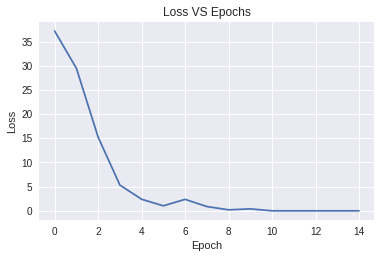

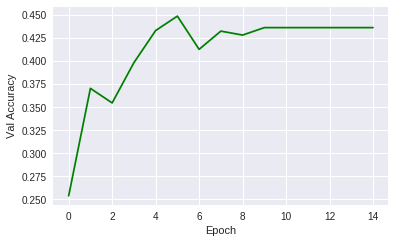

In [27]:

fig = plt.figure(figsize=(6, 8)) 
plt.subplot(2, 1, 1)
plt.plot(epoch_losses)
plt.title('Loss VS Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')



fig = plt.figure(figsize=(6, 8)) 
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy,'g')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')

plt.show()
plt.savefig('foo.png')

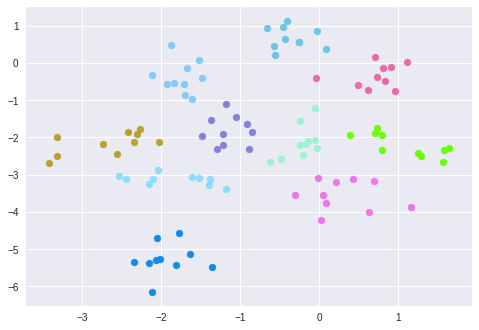

In [46]:
my_model.to_cpu()
plt.style.use('seaborn')
for particular_class_images in training_images:
    class_encodings = my_model.single_forward(particular_class_images)
    plt.scatter(class_encodings.data[:,0],class_encodings.data[:,1],color=np.random.random(3))
#plt.axis('off')
plt.savefig('cluster.png')
